In [185]:
import os
import pandas as pd
import numpy as np
import json
import joblib
import pickle
import requests
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score

from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
pd.set_option('display.max_columns', 500)

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from transformers.custom_transformers import DateTimeConverter, CalculateJailTime

import seaborn as sns



### Reading Data

In [186]:
df = pd.read_csv(r'/Users/joaopinto/projects/Capstone-LDSA/data/two-years-recid.csv')
df.head()

,id,name,sex,dob,age,race,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_charge_degree,c_charge_desc,juv_fel_count,juv_misd_count,juv_other_count,priors_count,compas_screening_date,type_of_assessment,decile_score,score_text,v_type_of_assessment,v_decile_score,v_score_text,is_recid,r_case_number,r_offense_date,r_charge_degree,r_charge_desc,is_violent_recid,vr_case_number,vr_offense_date,vr_charge_degree,vr_charge_desc,two_year_recid
0,1,steven lux,Male,1953-06-15,62,Caucasian,2013-01-05 04:35:31,2013-01-07 03:18:03,13000208CF10A,2013-01-05,NaN,F,False Imprisonment,0,0,0,0,2013-01-05,Risk of Recidivism,1,Low,Risk of Violence,1,Low,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
1,2,andre small,Male,1987-10-01,28,African-American,2013-04-02 12:18:46,2013-04-04 07:54:22,13006354MM10A,2013-04-02,NaN,M,Battery,0,0,0,1,2013-04-03,Risk of Recidivism,3,Low,Risk of Violence,3,Low,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
2,3,willie gray,Male,1959-01-12,57,African-American,2014-10-31 12:02:01,2014-10-31 01:47:05,14040148MU10A,2014-10-30,NaN,M,DUI Level 0.15 Or Minor In Veh,0,0,0,8,2014-10-31,Risk of Recidivism,4,Low,Risk of Violence,2,Low,1,15043364TC20A,2015-07-23,(M2),Driving License Suspended,0,NaN,NaN,NaN,NaN,1
3,4,nickson marcellus,Male,1996-07-11,19,African-American,2014-01-23 03:19:30,2014-01-23 01:04:34,13017969CF10A,NaN,2014-01-23,F,arrest case no charge,0,1,0,1,2014-01-23,Risk of Recidivism,10,High,Risk of Violence,10,High,1,16000241MM20A,2016-01-04,(M1),Possess Cannabis/20 Grams Or Less,0,NaN,NaN,NaN,NaN,1
4,5,patria barnes,Female,1978-06-06,37,Other,2013-12-08 01:55:28,2013-12-09 02:00:59,13022717MM10A,2013-12-07,NaN,M,Battery,0,0,0,0,2013-12-09,Risk of Recidivism,1,Low,Risk of Violence,1,Low,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0


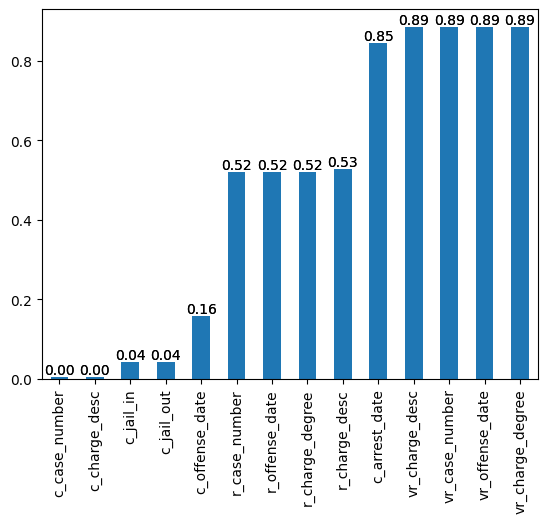

In [187]:
nas=df.isna().sum().apply(lambda x: x/len(df)).sort_values()
nas_plot= nas[nas!=0]
nas_plot.plot(kind='bar')
# Plot the bar chart
ax = nas_plot.plot(kind='bar', label=True)

# Add labels to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points')

# Display the plot
plt.show()

### Feature Engineering

#### Preprocessing

Text(0.5, 1.0, 'Recidivism Distribution')

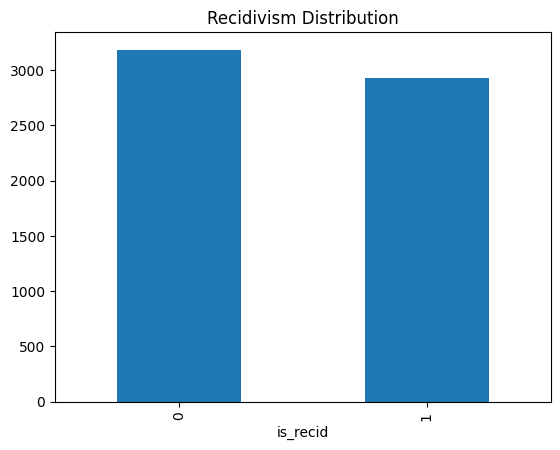

In [188]:
target = 'is_recid'
y = df[target]
y.value_counts().plot(kind='bar');
plt.title('Recidivism Distribution')

In [189]:

cols_to_keep=[  
 "id",
   "name",
   "sex",
   "dob",
   "race",
   "juv_fel_count", 
   "juv_misd_count",
   "juv_other_count",
   "priors_count",

 "c_case_number",
  "c_charge_degree",
  "c_charge_desc",
  "c_offense_date",
  "c_arrest_date",
  "c_jail_in",

 "is_recid",
#  "r_case_number",
#  "r_charge_degree",
#  "r_charge_desc",
#  "r_offense_date",
#
# "is_violent_recid",
#  "vr_case_number",
#  "vr_offense_date",
#  "vr_charge_degree",
#  "vr_charge_desc",
  ]

cols_to_keep

['id',
 'name',
 'sex',
 'dob',
 'race',
 'juv_fel_count',
 'juv_misd_count',
 'juv_other_count',
 'priors_count',
 'c_case_number',
 'c_charge_degree',
 'c_charge_desc',
 'c_offense_date',
 'c_arrest_date',
 'c_jail_in',
 'is_recid']

In [190]:
df = df[cols_to_keep]
X = df[[col for col in df.columns if col != target]]


drop_cols = [
    #'id',
    'name',
    'dob',
    'race',
    #'is_recid',
    #'c_jail_in',
    #'c_jail_out',
    'c_case_number',
    'c_offense_date',
    'c_arrest_date',
    
]
X = X.drop(columns=drop_cols).set_index('id')
print(X.columns)
X.head()


Index(['sex', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
       'priors_count', 'c_charge_degree', 'c_charge_desc', 'c_jail_in'],
      dtype='object')


,sex,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,c_charge_desc,c_jail_in
id,,,,,,,,
1,Male,0,0,0,0,F,False Imprisonment,2013-01-05 04:35:31
2,Male,0,0,0,1,M,Battery,2013-04-02 12:18:46
3,Male,0,0,0,8,M,DUI Level 0.15 Or Minor In Veh,2014-10-31 12:02:01
4,Male,0,1,0,1,F,arrest case no charge,2014-01-23 03:19:30
5,Female,0,0,0,0,M,Battery,2013-12-08 01:55:28


### Pipeline

In [191]:
# Define the initial numeric and categorical features
initial_numeric_features = [
    'age',
    'decile_score',
    'juv_fel_count',	
    'juv_misd_count',
    'juv_other_count',
    'priors_count',
]

categorical_features = [col for col in X.columns if col not in initial_numeric_features and col not in ['c_jail_out', 'c_jail_in']]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create the ColumnTransformer with an empty list of numeric features initially
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, selector(dtype_include=['int64', 'float64'])),
        ('cat', categorical_transformer, selector(dtype_include=['object', 'category']))
    ]
)
# Create the full pipeline including custom transformers
pipeline = Pipeline(steps=[
    #('datetime_converter', DateTimeConverter(columns=['c_jail_out', 'c_jail_in'])),
    #('jail_time_calculator', CalculateJailTime()),
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(C=0.1, penalty='l2', random_state=42))
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform Cross Validation
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x30a4ab340>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x30a4ab550>)])),
                ('classifier', LogisticRegression(C=0.1, random_state=42))])

In [192]:
# Predict on the test data
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='weighted')

# Calculate precision
precision = precision_score(y_test, y_pred, average='weighted')

# Calculate recall
recall = recall_score(y_test, y_pred, average='weighted')

# Print the metrics
print(f'Cross-Validation Accuracy Scores: {cv_scores}')
print(f'Mean Cross-Validation Accuracy: {cv_scores.mean()}')
print(f'Accuracy: {round(accuracy, 4)}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)
print(f'F1 Score: {round(f1, 4)}')
print(f'Precision: {round(precision, 4)}')
print(f'Recall: {round(recall, 4)}')

Cross-Validation Accuracy Scores: [0.66067048 0.6475879  0.65412919 0.683565   0.64566285]
Mean Cross-Validation Accuracy: 0.658323084684839
Accuracy: 0.6435
Confusion Matrix:
[[486 139]
 [297 301]]
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.78      0.69       625
           1       0.68      0.50      0.58       598

    accuracy                           0.64      1223
   macro avg       0.65      0.64      0.64      1223
weighted avg       0.65      0.64      0.64      1223

F1 Score: 0.6364
Precision: 0.6517
Recall: 0.6435


|    | Feature Name                                        |   Feature Importance |
|---:|:----------------------------------------------------|---------------------:|
|  0 | c_charge_desc_Voyeurism                             |            -1.04781  |
|  1 | c_charge_desc_Poss Of RX Without RX                 |             0.638399 |
|  2 | c_charge_desc_DUI Blood Alcohol Above 0.20          |            -0.605228 |
|  3 | juv_misd_count                                      |             0.582232 |
|  4 | c_charge_desc_Felony DUI - Enhanced                 |             0.464598 |
|  5 | c_charge_desc_Burglary Conveyance Assault/Bat       |             0.430653 |
|  6 | c_charge_desc_Opert With Susp DL 2nd Offens         |             0.413479 |
|  7 | c_charge_desc_Drivg While Lic Suspd/Revk/Can        |            -0.411924 |
|  8 | c_charge_desc_Agg Fleeing and Eluding               |            -0.405289 |
|  9 | c_charge_desc_DUI - Property Damage/Personal Injury |            -0.3

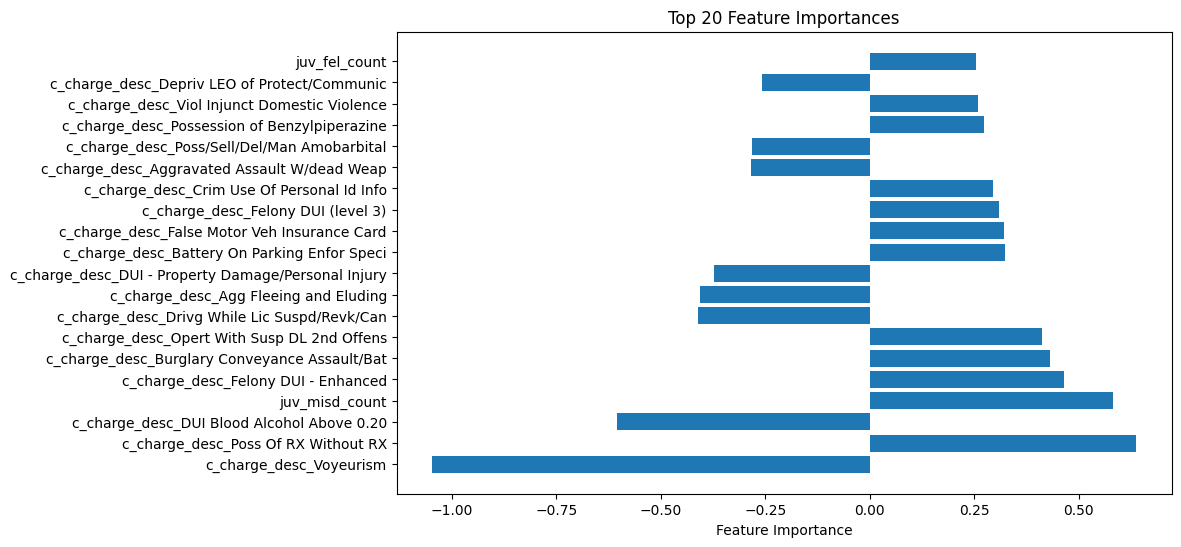

In [193]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the LogisticRegression classifier from the pipeline
classifier = pipeline.named_steps['classifier']

# Extract the one-hot encoder from the pipeline
onehot_encoder = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']

# Get original categorical feature names
categorical_features_original = [col for col in X.columns if col not in initial_numeric_features and col not in ['c_jail_out', 'c_jail_in']]

# Initialize list to store feature names
feature_names_encoded_with_original = []

# Iterate over each categorical feature and its one-hot encoded features
for feature_name, categories in zip(categorical_features_original, onehot_encoder.categories_):
    for category in categories:
        feature_names_encoded_with_original.append(f"{feature_name}_{category}")

# Combine all feature names
feature_names = initial_numeric_features + feature_names_encoded_with_original

# Get coefficients of the features from the classifier
coefficients = classifier.coef_[0]

# Combine feature names and coefficients
feature_importances = list(zip(feature_names, coefficients))

# Sort feature importances by their absolute values
feature_importances.sort(key=lambda x: abs(x[1]), reverse=True)

top = 20

# Extract top 10 features and their importances
top_features = [feature[0] for feature in feature_importances[:top]]
top_importances = [feature[1] for feature in feature_importances[:top]]


print(pd.DataFrame(feature_importances,columns=['Feature Name','Feature Importance']).head(20).to_markdown())

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(np.arange(len(top_features)), top_importances, align='center')
plt.yticks(np.arange(len(top_features)), top_features)
plt.xlabel('Feature Importance')
plt.title(f'Top {top} Feature Importances')
plt.show()


### Serialization

In [194]:
import joblib


with open('columns.json', 'w') as fh:
    json.dump(X_train.columns.tolist(), fh)
    

joblib.dump(pipeline, 'pipeline.pickle') 

['pipeline.pickle']

### Discrimination Test

In [195]:
grouped = X_test.reset_index().merge(df[['id','race','is_recid']],on='id',how='left')

grouped['Pred'] = y_pred
grouped = grouped.groupby('race').agg({'id':'count','Pred':'sum','is_recid':'sum'})

grouped['Recidivism Prediction %'] = (grouped['Pred'] / grouped['id']) * 100
grouped['Actual Recidivism %'] = (grouped['is_recid'] / grouped['id']) * 100
print(grouped.to_markdown())
grouped = grouped.reset_index()

| race             |   id |   Pred |   is_recid |   Recidivism Prediction % |   Actual Recidivism % |
|:-----------------|-----:|-------:|-----------:|--------------------------:|----------------------:|
| African-American |  639 |    279 |        360 |                   43.662  |               56.338  |
| Asian            |    7 |      2 |          2 |                   28.5714 |               28.5714 |
| Caucasian        |  422 |    125 |        178 |                   29.6209 |               42.1801 |
| Hispanic         |  100 |     22 |         32 |                   22      |               32      |
| Native American  |    4 |      2 |          3 |                   50      |               75      |
| Other            |   51 |     10 |         23 |                   19.6078 |               45.098  |


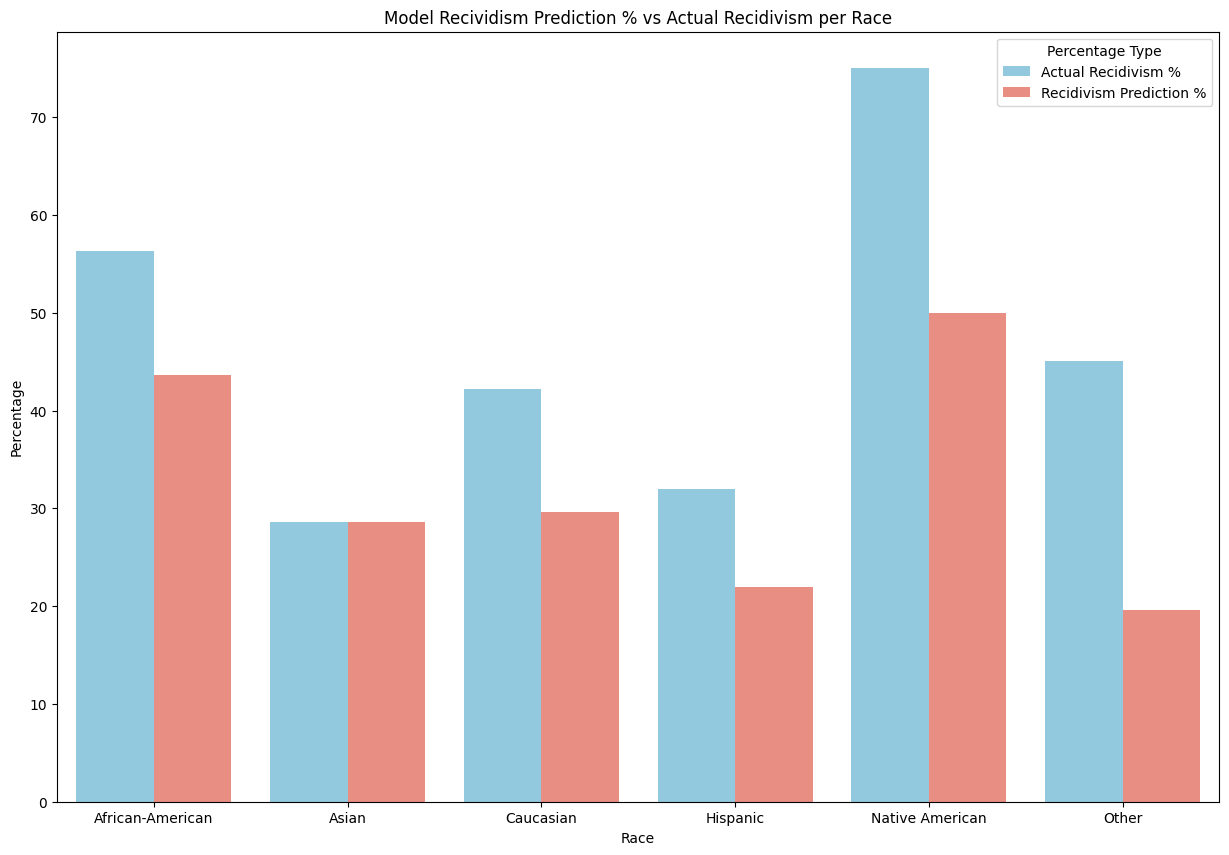

In [196]:

# Melt the DataFrame to a long format
grouped_melted = grouped.melt(id_vars='race', value_vars=['Actual Recidivism %','Recidivism Prediction %', ],
                              var_name='Percentage Type', value_name='Percentage')

plt.figure(figsize=(15, 10))

# Plot the bar plot with hue
sns.barplot(data=grouped_melted, x='race', y='Percentage', hue='Percentage Type', palette=['skyblue', 'salmon'])

# Set labels and titles
plt.title('Model Recividism Prediction % vs Actual Recidivism per Race')
plt.ylabel('Percentage')
plt.xlabel('Race')
plt.legend(title='Percentage Type', loc='upper right')
plt.show()

### Serialization

In [197]:
# Serialize the column names from the X DataFrame into a file named columns.json
# YOUR CODE HERE
with open( "columns.json", 'w') as fh:
    json.dump(X_train.columns.tolist(), fh)

# Pickle the dtypes of the columns from the X DataFrame into a file named dtypes.pickle
# YOUR CODE HERE
with open('dtypes.pickle', 'wb') as fh:
    pickle.dump(X_train.dtypes, fh)
    
# Pickle the fitted pipeline into a file named pipeline.pickle
# YOUR CODE HERE
import joblib
joblib.dump(pipeline, 'pipeline.pickle');

### Model Choice

In [199]:
print('Change')
raise ValueError
# Define a dictionary of models with their respective parameter grids for hyperparameter tuning
models = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {
            'classifier__C': [0.1, 1.0, 10.0],
            'classifier__penalty': ['l1', 'l2']
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'classifier__max_depth': [None, 5, 10, 20],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4]
        }
    },
    #'Random Forest': {
    #    'model': RandomForestClassifier(),
    #    'params': {
    #        'classifier__n_estimators': [100, 200, 300],
    #        'classifier__max_depth': [None, 5, 10, 20],
    #        'classifier__min_samples_split': [2, 5, 10],
    #        'classifier__min_samples_leaf': [1, 2, 4],
    #        'classifier__bootstrap': [True, False]
    #    }
    #},
    #'Support Vector Machine': {
    #    'model': SVC(),
    #    'params': {
    #        'classifier__C': [0.1, 1.0, 10.0],
    #        'classifier__kernel': ['linear', 'rbf']
    #    }
    #},
    #'AdaBoost': {
    #    'model': AdaBoostClassifier(),
    #    'params': {
    #        'classifier__n_estimators': [50, 100, 200],
    #        'classifier__learning_rate': [0.01, 0.1, 1.0]
    #    }
    #},
    #'Gradient Boosting': {
    #    'model': GradientBoostingClassifier(),
    #    'params': {
    #        'classifier__n_estimators': [50, 100, 200],
    #        'classifier__learning_rate': [0.01, 0.1, 1.0],
    #        'classifier__max_depth': [3, 5, 7]
    #    }
    #},
    #'K-Nearest Neighbors': {
    #    'model': KNeighborsClassifier(),
    #    'params': {
    #        'classifier__n_neighbors': [3, 5, 7],
    #        'classifier__weights': ['uniform', 'distance']
    #    }
    #},
    #'Multi-layer Perceptron': {
    #    'model': MLPClassifier(),
    #    'params': {
    #        'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50, 25)],
    #        'classifier__activation': ['logistic', 'relu'],
    #        'classifier__alpha': [0.0001, 0.001, 0.01]
    #    }
    #}
}

# Test each model using grid search for hyperparameter tuning
for name, model_info in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model_info['model'])])
    
    grid_search = GridSearchCV(pipeline, model_info['params'], cv=5, scoring='f1')
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"F1 Score: {round(grid_search.best_score_,2)}")


Change


ValueError: 